# Plot syllable classifier predicting syllable identity or syllable clusters from dLight waveforms

In [18]:
import toml
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from os.path import join
from tqdm.auto import tqdm
from toolz import keymap, valfilter
from scipy.cluster import hierarchy
from rl_analysis import ANALYSIS_CONFIG
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests
from rl_analysis.plotting import save_factory, fg, add_legend, setup_plotting_env, clean_ticks, COLORS

warnings.simplefilter('ignore')

In [5]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

In [7]:
setup_plotting_env()

saver = save_factory(join(config['figures']['dir_wg'], 'fig-01'), tight_layout=False)

In [19]:
# load offline syllable stats
with open(
    join(
        config["data_dirs"]["root_wg"],
        config["intermediate_results"]["dlight_syllable_stats"]["offline"],
    ),
    "r",
) as f:
    syll_stats = toml.load(f)
    relabel_map = keymap(int, syll_stats["syllable_to_sorted_idx"])
    relabel_map = valfilter(lambda v: v < syll_stats["truncate"], relabel_map)
    if -5 in relabel_map:
        del relabel_map[-5]

## Load data

In [8]:
# newest behavioral distance that JM computed: 12-17-21
bdist_path = '/home/wg41/reinforcement_data/processed-dfs/behavioral-distance.parquet'
bdists = pd.read_parquet(bdist_path)

# cols and rows are syll ID
bdists.columns = bdists.columns.map(int)

In [10]:
to_keep = list(relabel_map)

In [11]:
len(to_keep)

37

In [12]:
distance_mtx = bdists.loc[to_keep, to_keep]

z = hierarchy.complete(squareform(distance_mtx))

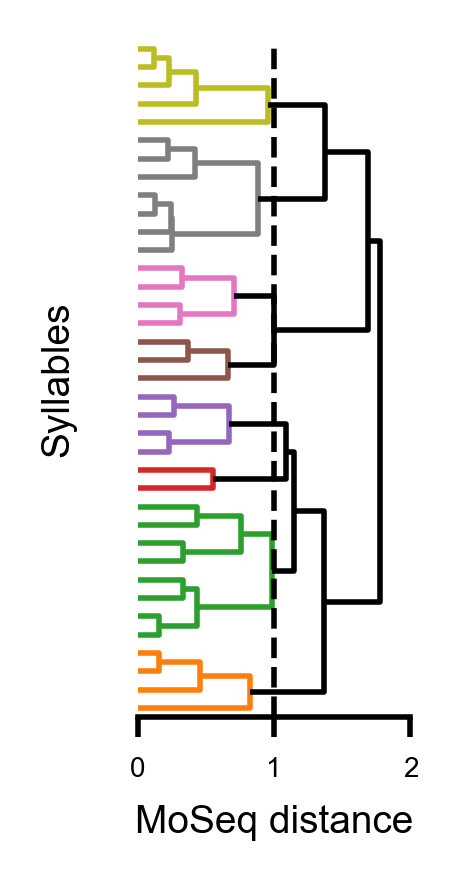

In [15]:
fig = fg(0.88, 2.2)
fig.dpi = 200
hierarchy.dendrogram(z, above_threshold_color='k', color_threshold=1, orientation='right')

plt.xlabel('MoSeq distance')
ax = plt.gca()
ax.set_yticklabels([])
sns.despine(left=True)
plt.axvline(1, color='k', linestyle='--', linewidth=1)
plt.ylabel('Syllables')
plt.xlim(0, 2)
plt.xticks([0, 1, 2])
saver(fig, 'behavior-dendrogram-moseq-dist');

## Combine model runs

In [20]:
# find and load data
metric_files = glob(
    "/home/wg41/reinforcement_data/dlight/syllable-classifier-submission/**/*.parquet"
)
combined_df = pd.concat((pd.read_parquet(f) for f in tqdm(metric_files)), ignore_index=True)

combined_df["Percent correct"] = combined_df["accuracy"] * 100

combined_df["type"] = combined_df["type"].map({"shuffle": "Shuffle", "dLight": "dLight"})

  0%|          | 0/1096 [00:00<?, ?it/s]

In [21]:
combined_df['type'].unique()

array(['Shuffle', 'dLight'], dtype=object)

## Syllable classifier using dLight waveforms

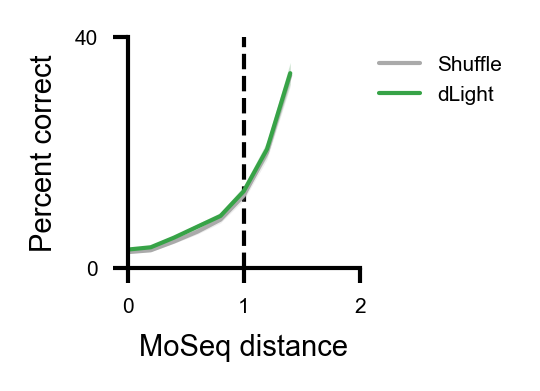

In [25]:
fig = fg(1, 1)
fig.dpi = 150
ax = sns.lineplot(
    data=combined_df.query('threshold < 1.5'),  # 1.6 is a repeat of 1.4
    x="threshold",
    y="Percent correct",
    hue="type",
    palette=[(170 / 255,) * 3, COLORS['green']],
    linewidth=1,
    hue_order=["Shuffle", "dLight"],
    ci='sd',
    err_kws=dict(linewidth=0),
)
plt.xlabel("MoSeq distance")
add_legend(ax)
plt.xlim(0, 2)
plt.ylim(0, 40)
plt.xticks([0, 1, 2])
clean_ticks(ax, axis="y", precision=1, zero_symmetry=False, dtype=int)
plt.axvline(1, linewidth=1, linestyle="--", color="k", zorder=-5)
sns.despine()
saver(fig, "dlight-behavior-classifier");

In [26]:
# statistics: non-parametric
pvals = {}
statistics = {}
for thresh, _df in combined_df.groupby("threshold"):
    _df = _df.set_index("type")
    # because data are (re)sampled, assuming bootstrap statistics
    pvals[round(thresh, 2)] = np.mean(
        _df.loc["Shuffle", "Percent correct"] > _df.loc["dLight", "Percent correct"].mean()
    )

In [28]:
new_pvals = dict(zip(pvals, multipletests(list(pvals.values()), method='bonferroni')[1]))
new_pvals

{0.0: 0.13012048192771083,
 0.2: 0.06325301204819277,
 0.4: 0.14096385542168677,
 0.6: 0.22951807228915663,
 0.8: 1.0,
 1.0: 1.0,
 1.2: 1.0,
 1.4: 1.0,
 1.6: 1.0}

## Syllable classifier using dLight amplitudes

In [29]:
# find and load data
metric_files = glob(
    "/home/wg41/reinforcement_data/dlight/syllable-classifier-from-dlight-amplitude-submission/**/*.parquet"
)
combined_df = pd.concat((pd.read_parquet(f) for f in tqdm(metric_files)), ignore_index=True)

combined_df["Percent correct"] = combined_df["accuracy"] * 100

combined_df["type"] = combined_df["type"].map({"shuffle": "Shuffle", "dLight": "dLight"})

  0%|          | 0/1496 [00:00<?, ?it/s]

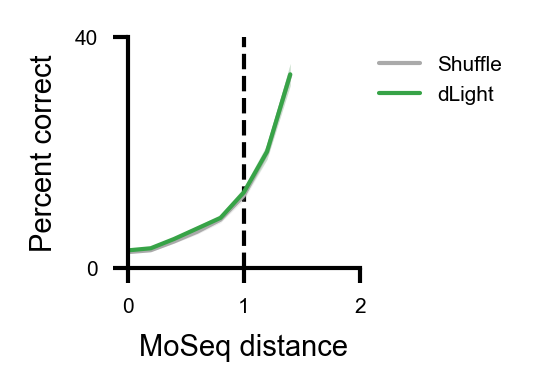

In [30]:
fig = fg(1, 1)
fig.dpi = 150
ax = sns.lineplot(
    data=combined_df.query('threshold < 1.5'),
    x="threshold",
    y="Percent correct",
    hue="type",
    palette=[(170 / 255,) * 3, COLORS['green']],
    linewidth=1,
    hue_order=["Shuffle", "dLight"],
    ci='sd',
    err_kws=dict(linewidth=0),
)
plt.xlabel("MoSeq distance")
add_legend(ax)
plt.xlim(0, 2)
plt.ylim(0, 40)
plt.xticks([0, 1, 2])
clean_ticks(ax, axis="y", precision=1, zero_symmetry=False, dtype=int)
plt.axvline(1, linewidth=1, linestyle="--", color="k", zorder=-5)
sns.despine()
saver(fig, "dlight-amplitude-behavior-classifier");

In [31]:
# statistics: non-parametric
pvals = {}
statistics = {}
for thresh, _df in combined_df.groupby('threshold'):
    _df = _df.set_index('type')
    pvals[round(thresh, 2)] = np.mean(_df.loc['Shuffle', 'Percent correct'] > _df.loc['dLight', 'Percent correct'].mean())

In [32]:
pvals

{0.0: 0.05115346038114343,
 0.2: 0.04674022066198596,
 0.4: 0.080641925777332,
 0.6: 0.09869608826479438,
 0.8: 0.28044132397191573,
 1.0: 0.25897693079237716,
 1.2: 0.43430290872617855,
 1.4: 0.4954864593781344,
 1.6: 0.48004012036108323}

In [33]:
new_pvals = dict(zip(pvals, multipletests(list(pvals.values()), method='bonferroni')[1]))
new_pvals

{0.0: 0.46038114343029085,
 0.2: 0.42066198595787363,
 0.4: 0.7257773319959879,
 0.6: 0.8882647943831494,
 0.8: 1.0,
 1.0: 1.0,
 1.2: 1.0,
 1.4: 1.0,
 1.6: 1.0}